# Meshing in Spyro

This tutorial was prepared by Alexandre Olender. If you have any questions, please email: olender@usp.br

Meshing is a complex problem frequently encountered in Seismic imaging. For seismic imaging based on higher-order finite element methods, such as Spectral Element Methods of higher-order mass lumped triangles, adequate meshing is a computational necessity. Using higher-order FEM without any specific mesh considerations will usually give results computationally significantly more expensive than finite difference-based wave solvers. This inherent meshing complexity tends to turn users away from FEM-based solvers. Spyro aims to treat most seismic imaging-based problems with little user input relative to generating meshes, removing the additional complexity encountered by an end-user when propagating waves. 

Wave solvers in Spyro can automatically create meshes based on the inputs of the dictionary parameters. For most users, this will be enough. For these automatic mesh capabilities, please see the **simple forward exercises** and the **simple forward with overthrust** tutorials. This tutorial is only geared for more advanced users who need to directly call on the `AutomaticMesh` class or develop inside it.

In [1]:
# Code in this cell enables plotting in the notebook
%matplotlib inline

import spyro

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance



In Spyro, we use the Firedrake meshing utilities and a Python package for simplex (2D triangles and 3D tetrahedral) mesh generation called SeismicMesh. A user can input Gmsh-generated meshes (see https://www.firedrakeproject.org/demos/immersed_fem.py.html) and also create meshes separately in SeismicMesh (https://doi.org/10.21105/joss.02687). Any mesh compatible with Firedrake is compatible with Spyro. Here, we will use Spyro's wrappers for Firedrake and SeismicMesh for mesh generation. This should be enough for any synthetic or complex real seismic imaging problem. However, if you are using Spyro for other cases, creating those meshes in either Gmsh or SeimicMesh might be necessary.

## Automatic Mesh class

For the Automatic mesh class, we use Firedrake and SeismicMesh-based wrappers. Almost every option is based on the weird seismic orientation we found in segy files. The axis orders are z, x, and y for 3D and z, x for 2D, with z coordinates going in the negative direction. We can learn more about this class using Python's help method.

In [2]:
help(spyro.meshing.AutomaticMesh)

Help on class AutomaticMesh in module spyro.meshing.meshing_functions:

class AutomaticMesh(builtins.object)
 |  AutomaticMesh(comm=None, mesh_parameters=None)
 |  
 |  Class for automatic meshing.
 |  
 |  Attributes
 |  ----------
 |  dimension : int
 |      Spatial dimension of the mesh.
 |  length_z : float
 |      Length of the domain in the z direction.
 |  length_x : float
 |      Length of the domain in the x direction.
 |  length_y : float
 |      Length of the domain in the y direction.
 |  dx : float
 |      Mesh size.
 |  quadrilateral : bool
 |      If True, the mesh is quadrilateral.
 |  periodic : bool
 |      If True, the mesh is periodic.
 |  comm : MPI communicator
 |      MPI communicator.
 |  mesh_type : str
 |      Type of the mesh.
 |  abc_pad : float
 |      Padding to be added to the domain.
 |  
 |  Methods
 |  -------
 |  set_mesh_size(length_z=None, length_x=None, length_y=None)
 |      Sets the mesh size.
 |  set_meshing_parameters(dx=None, cell_type=None, m

As with everything in Python, help() provides information based on the documentation written inside the code.  Let us highlight the notes on the init method:

Notes
-----
The `mesh_parameters` dictionary should contain the following keys:
 - 'dimension': int, optional. Dimension of the mesh. The default is 2.
 - 'length_z': float, optional. Length of the mesh in the z-direction.
 - 'length_x': float, optional. Length of the mesh in the x-direction.
 - 'length_y': float, optional. Length of the mesh in the y-direction.
 - 'cell_type': str, optional. Type of the mesh cells.
 - 'mesh_type': str, optional. Type of the mesh.

For mesh with absorbing layer only:
 - 'abc_pad_length': float, optional. Length of the absorbing boundary condition padding.

For Firedrake mesh only:
 - 'dx': float, optional. Mesh element size.
 - 'periodic': bool, optional. Whether the mesh is periodic.
 - 'edge_length': float, optional. Length of the mesh edges.

 For SeismicMesh only:
 - 'cells_per_wavelength': float, optional. Number of cells per wavelength.
 - 'source_frequency': float, optional. Frequency of the source.
 - 'minimum_velocity': float, optional. Minimum velocity.
 - 'velocity_model_file': str, optional. File containing the velocity model.
 - 'edge_length': float, optional. Length of the mesh edges.

## Firedrake based meshes

We can use the Firedrake-based meshes. These take the dictionary inputs and place them in the appropriate 2D or 3D wrappers of Firedrake functions, for 2D Firedrake provides a `RectangleMesh` object.

In [3]:
import firedrake as fire
help(fire.RectangleMesh)

Help on cython_function_or_method in module firedrake.utility_meshes:

RectangleMesh(nx, ny, Lx, Ly, quadrilateral=False, reorder=None, diagonal='left', distribution_parameters=None, comm=<mpi4py.MPI.Intracomm object at 0x7f9033d71350>, name='firedrake_default', distribution_name=None, permutation_name=None)
    Generate a rectangular mesh
    
    :arg nx: The number of cells in the x direction
    :arg ny: The number of cells in the y direction
    :arg Lx: The extent in the x direction
    :arg Ly: The extent in the y direction
    :kwarg quadrilateral: (optional), creates quadrilateral mesh, defaults to False
    :kwarg reorder: (optional), should the mesh be reordered
    :kwarg comm: Optional communicator to build the mesh on (defaults to
        COMM_WORLD).
    :kwarg diagonal: For triangular meshes, should the diagonal got
        from bottom left to top right (``"right"``), or top left to
        bottom right (``"left"``), or put in both diagonals (``"crossed"``).
    :kwarg 

Based on the above documentation, please create a 10-element by 20-element quadrilateral mesh with the first axis (representing Z) of length 1.5 km and the second axis (representing X) of length 3 km.

In [4]:
nz = 10
nx = 20
length_z = 1.5
length_x = 3.0

mesh = fire.RectangleMesh(nz, nx, length_z, length_x, quadrilateral=True)

Let us have a look at our mesh:

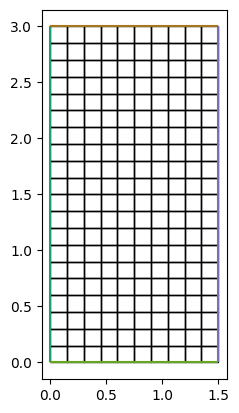

In [5]:
from firedrake import triplot
import matplotlib.pyplot as plt

fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.set_aspect("equal")

As shown above, see Z is still positive. We can alter the coordinates in mesh.coordinates.dat.data. Please try to do this below.

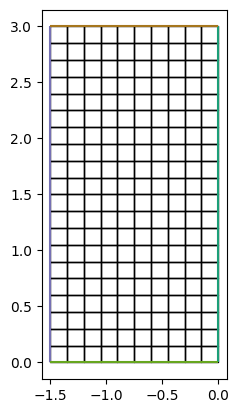

In [6]:
mesh.coordinates.dat.data[:, 0] *= -1.0

fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.set_aspect("equal")

Our wrapper also adds a pad option and dislocates it appropriately (with zero starting in the domain of interest). Below, we show this wrapper (located in spyro.meshing.RectangleMesh) with the comm variable removed:

In [7]:
def RectangleMesh(nx, ny, Lx, Ly, pad=None, quadrilateral=False):
    """Create a rectangle mesh based on the Firedrake mesh.
    First axis is negative, second axis is positive. If there is a pad, both
    axis are dislocated by the pad.

    Parameters
    ----------
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.
    nx : int
        Number of elements in the x direction.
    ny : int
        Number of elements in the y direction.
    pad : float, optional
        Padding to be added to the domain. The default is None.
    comm : MPI communicator, optional
        MPI communicator. The default is None.
    quadrilateral : bool, optional
        If True, the mesh is quadrilateral. The default is False.

    Returns
    -------
    mesh : Firedrake Mesh
        Mesh
    """
    if pad is not None:
        Lx += pad
        Ly += 2 * pad
    else:
        pad = 0
    mesh = fire.RectangleMesh(nx, ny, Lx, Ly, quadrilateral=quadrilateral)
    mesh.coordinates.dat.data[:, 0] *= -1.0
    mesh.coordinates.dat.data[:, 1] -= pad

    return mesh


Let us use it to alter the example below and add a 0.5km pad.

In [8]:
nz = 10
nx = 20
length_z = 1.5
length_x = 3.0
pad = 0.5
quad = True
mesh = RectangleMesh(nz, nx, length_z, length_x, pad=0.5, quadrilateral=quad)

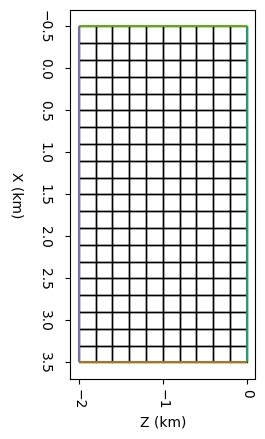

In [9]:
fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.invert_yaxis()
axes.set_xlabel("Z (km)")
axes.set_ylabel("X (km)", rotation=-90, labelpad=20)
plt.setp(axes.get_xticklabels(), rotation=-90, va="top", ha="center")
plt.setp(axes.get_yticklabels(), rotation=-90, va="center", ha="left")
axes.tick_params(axis='y', pad=20)
axes.set_aspect("equal")

We use similar wrappers for 3D hexahedral and tetrahedral meshes, shown below as:

In [10]:
def BoxMesh(nx, ny, nz, Lx, Ly, Lz, pad=None, quadrilateral=False):
    if pad is not None:
        Lx += pad
        Ly += 2 * pad
        Lz += 2 * pad
    else:
        pad = 0
    if quadrilateral:
        quad_mesh = fire.RectangleMesh(nx, ny, Lx, Ly, quadrilateral=quadrilateral)
        quad_mesh.coordinates.dat.data[:, 0] *= -1.0
        quad_mesh.coordinates.dat.data[:, 1] -= pad
        layer_height = Lz / nz
        mesh = fire.ExtrudedMesh(quad_mesh, nz, layer_height=layer_height)
    else:
        mesh = fire.BoxMesh(nx, ny, nz, Lx, Ly, Lz)
        mesh.coordinates.dat.data[:, 0] *= -1.0

    return mesh

You will notice that an extruded rectangle mesh is used for hexahedral elements. This is necessary for Firedrake to take advantage of sum factorization in spectral elements. The layer height can be adjusted and be different for every layer. The 2D mesh to be extruded can be replaced with an unstructured quadrilateral mesh.

## SeismicMesh

Please contribute to SeismicMesh and collaborate with Dr. Keith Richards for any improvements in our meshing algorithm. SeismicMesh has extensive documentation and demos at https://seismicmesh.readthedocs.io/en/par3d/. The current 2D wrapper in use is located in spyro.meshing.AutomaticMesh.create_seismicmesh_2d_mesh_with_velocity_model, but we refer to the SeismicMesh repository for tutorials and demos. 

It is essential to understand the required mesh resolution for a given desired accuracy to apply higher-order mass-lumped methods with unstructured meshes effectively. Here, we will only focus on the cells-per-wavelength parameter. To better understand this parameter relative to acoustic waves with simplexes, please read the Spyro paper or ask at olender@usp.br. If you want to use different wave equations, calculating new parameters is necessary but straightforward with the cells_per_wavelength_calculator located inside the tools package. If you need any help using the previously mentioned tool, please contact the developer of this specific tool (Alexandre Olender) only after implementing and verifying your new wave equation.

For acoustic waves, just follow the updated table below when calling SeismicMesh:

| Element      | CPW |
| ----------- | ----------- |
| mlt2tri      | 7.20       |
| mlt3tri   | 3.97        |
| mlt4tri   | 2.67        |
| mlt5tri   | 2.03        |
| mlt6tri   | 1.50        |
| mlt2tet   | 6.12        |
| mlt3tet   | 3.72        |

Let us create meshes for mlt2tri and mlt6tri elements and compare them based on a cut Overthrust model. The dimensions are length_z = 2.8 km and length_x = 6.0 km. The Ricker source has a peak frequency of 5 Hz. A pad of abc_pad = 0.75 km was added. Please complete the code below:

In [11]:
frequency = 5.0  # ANSWER
length_z = 2.8  # ANSWER
length_x = 6.0  # ANSWER
abc_pad = 0.75  # ANSWER

cells_per_wavelength = 7.20  # ANSWER

# SeismicMesh takes length parameters in meters, even though the velocity paramter can be in km/s
length_z *= 1000
length_x *= 1000
abc_pad *= 1000

We also need to input the minimum element length. This occurs where velocity has the smallest value in our Overthurst model, representing the water layer, with 1.5 km/s.

In [12]:
v_min = 1.5
lbda_min = v_min/frequency  # ANSWER
h_min = lbda_min/cells_per_wavelength

h_min *= 1000

We need to build a box and domain with our corner coordinates. 

In [13]:
import SeismicMesh

bbox = (-length_z, 0.0, 0.0, length_x)
domain = SeismicMesh.Rectangle(bbox)

Seismic mesh can now calculate the necessary element sizes across the domain using its `get_sizing_from_segy` method. If the file were a segy, the code below would run without errors.

In [14]:
ef = SeismicMesh.get_sizing_function_from_segy(
    "velocity_models/cut_overthrust_binary.bin",
    bbox,
    hmin=h_min,
    wl=cells_per_wavelength,
    freq=frequency,
    grade=0.15,
    domain_pad=abc_pad,
    pad_style="edge",
    units='km/s',
)

IndexError: list index out of range

Even though segy files are the norm in Seismic imaging, binary files are also common. This is a severe hindrance if you need to learn how the binary file is organized. However, most binaries used in seismic imaging to represent velocity files are organized similarly. To use these files in SeismicMesh, you have to pass the number of elements in each direction, axes order, byte order, and dtype. 

In [15]:
nz, nx, ny = 140, 300, 0

ef = SeismicMesh.get_sizing_function_from_segy(
    "velocity_models/cut_overthrust_binary.bin",
    bbox,
    hmin=h_min,
    wl=cells_per_wavelength,
    freq=frequency,
    grade=0.15,
    domain_pad=abc_pad,
    pad_style="edge",
    units='km/s',
    nz=nz,
    nx=nx,
    ny=ny,
    axes_order=(1, 0),
    byte_order="little",
    dtype="int32",
)

Reading binary file: velocity_models/cut_overthrust_binary.bin
Mesh sizes will be built to resolve an estimate of wavelength of a 5.0 hz wavelet with 7.2 vertices...
Enforcing minimum edge length of 41.666666666666664
Enforcing maximum edge length of 10000.0
Enforcing mesh size gradation of 0.15 decimal percent...
Including a 750.0 meter domain extension...
Using the pad_style: edge


We can now create our mesh

In [16]:
points, cells = SeismicMesh.generate_mesh(
    domain=domain,
    edge_length=ef,
    verbose=0,
)

We can save our mesh using meshio. If necessary, we can convert the coordinates back to km here. The vtk file is just for Paraview visualization.

In [17]:
import meshio

meshio.write_points_cells(
    "meshing_tutorial_mesh.msh",
    points/1000.0,
    [("triangle", cells)],
    file_format="gmsh22",
    binary=False
)

meshio.write_points_cells(
    "meshing_tutorial_mesh.vtk",
    points/1000.0,
    [("triangle", cells)],
    file_format="vtk"
)

Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Let us load our mesh into Firedrake so we can have a look at it

In [18]:
mesh = fire.Mesh(
    'meshing_tutorial_mesh.msh',
    distribution_parameters={
        "overlap_type": (fire.DistributedMeshOverlapType.NONE, 0)
    },
)

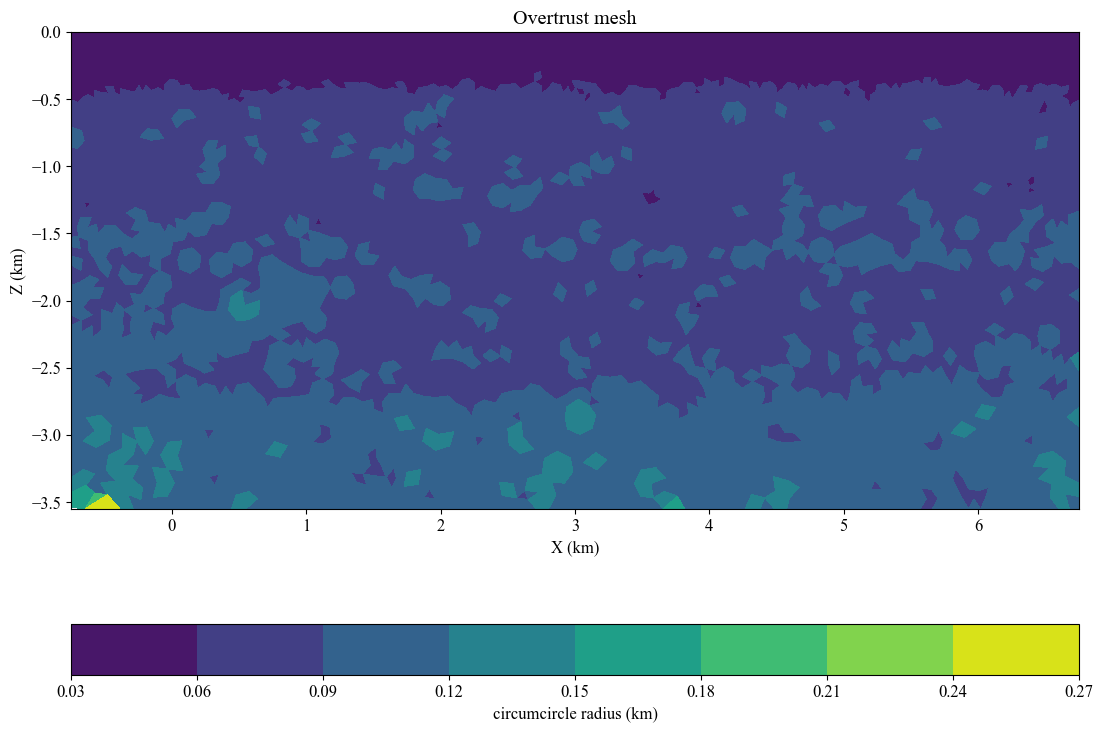

In [19]:
spyro.plots.plot_mesh_sizes(
    firedrake_mesh=mesh,
    title_str="Overtrust mesh",
    show=True,
)

The above mesh has elements varying from 30 meters to 270 meters. Total DoFs can give us an idea of computational storage and runtime costs. Since we are using ML2Tri, we must look at the nodes inside each element, not just the vertices. For the above problem, the total DoFs are:

In [20]:
element = fire.FiniteElement("KMV", mesh.ufl_cell(), degree=2, variant="KMV")
space = fire.FunctionSpace(mesh, element)
print(f"Total Dofs for ml2tri function space:{space.dim()}")

Total Dofs for ml2tri function space:36709


For comparison, let us create the same mesh and function space using ml4tri elements

In [21]:
frequency = 5.0
length_z = 2.8
length_x = 6.0
abc_pad = 0.75

cells_per_wavelength = 2.67 # ANSWER

# SeismicMesh takes length parameters in meters, even though the velocity paramter can be in km/s
length_z *= 1000
length_x *= 1000
abc_pad *= 1000

v_min = 1.5
lbda_min = v_min/frequency
h_min = lbda_min/cells_per_wavelength

h_min *= 1000

bbox = (-length_z, 0.0, 0.0, length_x)
domain = SeismicMesh.Rectangle(bbox)

nz, nx, ny = 140, 300, 0

ef = SeismicMesh.get_sizing_function_from_segy(
    "velocity_models/cut_overthrust_binary.bin",
    bbox,
    hmin=h_min,
    wl=cells_per_wavelength,
    freq=frequency,
    grade=0.15,
    domain_pad=abc_pad,
    pad_style="edge",
    units='km/s',
    nz=nz,
    nx=nx,
    ny=ny,
    axes_order=(1, 0),
    byte_order="little",
    dtype="int32",
)

points, cells = SeismicMesh.generate_mesh(
    domain=domain,
    edge_length=ef,
    verbose=0,
)

meshio.write_points_cells(
    "new_meshing_tutorial_mesh.msh",
    points/1000.0,
    [("triangle", cells)],
    file_format="gmsh22",
    binary=False
)

meshio.write_points_cells(
    "new_meshing_tutorial_mesh.vtk",
    points/1000.0,
    [("triangle", cells)],
    file_format="vtk"
)

new_mesh = fire.Mesh(
    'new_meshing_tutorial_mesh.msh',
    distribution_parameters={
        "overlap_type": (fire.DistributedMeshOverlapType.NONE, 0)
    },
)

Reading binary file: velocity_models/cut_overthrust_binary.bin
Mesh sizes will be built to resolve an estimate of wavelength of a 5.0 hz wavelet with 2.67 vertices...
Enforcing minimum edge length of 112.35955056179775
Enforcing maximum edge length of 10000.0
Enforcing mesh size gradation of 0.15 decimal percent...
Including a 750.0 meter domain extension...
Using the pad_style: edge


Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Let us have a look at the new mesh

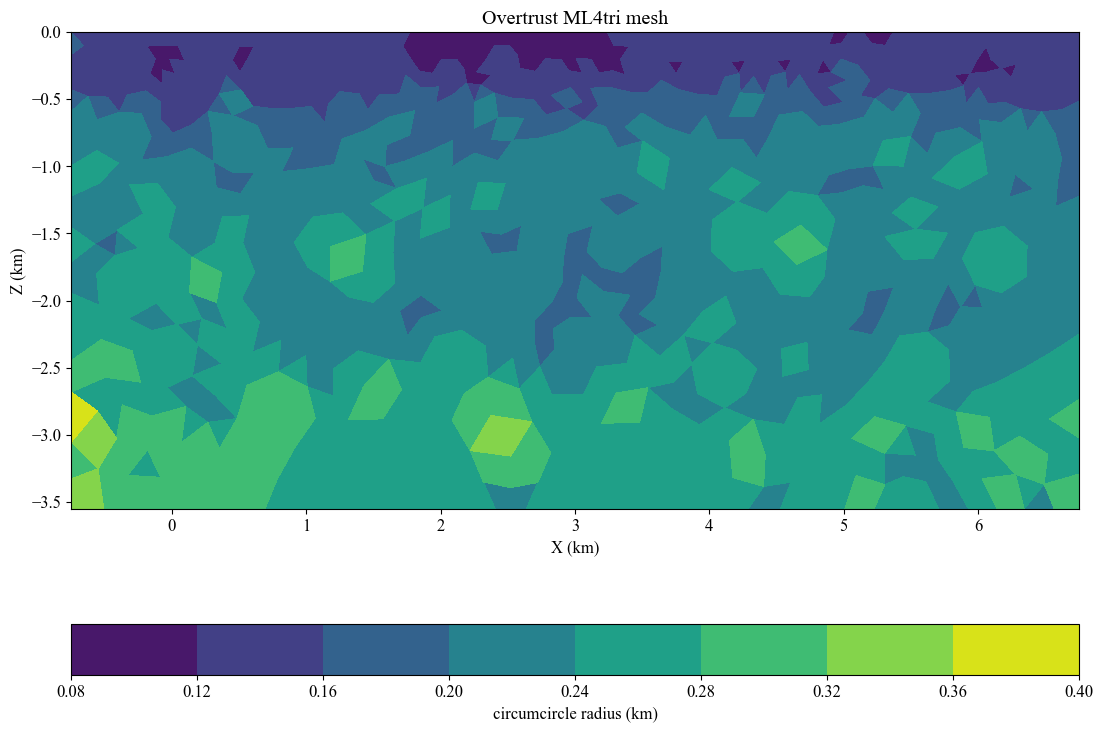

In [22]:
spyro.plots.plot_mesh_sizes(
    firedrake_mesh=new_mesh,
    title_str="Overtrust ML4tri mesh",
    show=True,
)

As you can see, our element sizes are considerably bigger, varying from 80 to 400 meters. Larger elements for the same domain mean fewer elements. However, does this translate to fewer DoFs? A single ml4tri element has more DoFs than a single ML2tri element, so the tradeoff is only sometimes clear. Let us calculate the new total DoFs:

In [23]:
element = fire.FiniteElement("KMV", new_mesh.ufl_cell(), degree=4, variant="KMV")
space = fire.FunctionSpace(new_mesh, element)
print(f"Total Dofs for ml4tri function space:{space.dim()}")

Total Dofs for ml4tri function space:18798


As you can see using the 4th order element we have greatly reduced our total DoFs!